# 3. 실시간 영상으로 운동분류

In [2]:
# library
import math
import cv2
import numpy as np
import pandas as pd
from time import time
import mediapipe as mp
import matplotlib.pyplot as plt
import pickle
import joblib
import sklearn

In [6]:
# load mediapipe pose
mp_pose = mp.solutions.pose

# mediapipe setting
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.3, model_complexity=2)
# MIN_DETECTION_CONFIDENCE : 최소 감지 신뢰도
# MIN_TRACKING_CONFIDENCE : 최소 트랙킹 신뢰도. 이미지 사람없으면 다음 이미지로 자동으로 넘어가서 추적하는데, static_image_mode=True라면 그 기능 무시하고 모든 이미지에서 실행.
# MIN_TRACKING_CONFIDENCE : 값 높게하면 솔루션 견고성 높아지지만 학습시간 길어짐
# model_complexity (0 or 1 or 2) : 랜드마크 정확도와 추론 지연 시간은 일반적으로 모델의 복잡성에 따라 증가

# mediapipe drawing util
mp_drawing = mp.solutions.drawing_utils 

In [7]:
print('hello')

hello


In [8]:
# define "calculateAngle" model
    # Args :
        ## landmark1 : 1st (x,y,z)
        ## landmark2 : 2nd (x,y,z)
        ## landmark3 : 3rd (x,y,z)
    # Returns :
        ## angle : between 1,2,3
        
def calculateAngle(landmark1, landmark2, landmark3):

    # get landmarks
    x1, y1= landmark1
    x2, y2= landmark2
    x3, y3= landmark3

    # calculatate with math
    # math.atan2(y, x) : 탄젠트의 역함수. atan과 다르게 atan2는 x축으로부터 반시계방향으로 각도를 계산. 이후 라디안 값으로 뱉어냄
    # math.degrees : 라디안값을 각도로 변경해주는 함수
    angle = math.degrees(math.atan2(y3 - y2, x3 - x2) - math.atan2(y1 - y2, x1 - x2))
    
    # find opposite angle
    if angle < 0.0:
        angle += 360
    if angle >180.0:
        angle = 360.0 - angle
  
    # iterate
    return angle

In [9]:
# 두 측정점과 지면과의 각도 구하는 함수

def calculateAngle2(landmark1, landmark2):

    # get landmarks
    x1, y1= landmark1
    x2, y2= landmark2
    x3 = x2
    y3 = y2 + 1
    
    # calculate with math
    angle = math.degrees(math.atan2(y3 - y2, x3 - x2) - math.atan2(y1 - y2, x1 - x2))
    
    # find opposite angle
    if angle < 0.0:
        angle += 360
    if angle >180.0:
        angle = 360.0 - angle
  
    # iterate
    return angle

In [10]:
# calculateAngle 함수와 기능은 같지만 다르게 짠 코드

def calculateAngle3(landmark1, landmark2, landmark3):
    x1, y1= landmark1
    x2, y2= landmark2
    x3, y3= landmark3
    
    # calculate angle
    radians = np.arctan2(y3-y2, x3-x2) - np.arctan2(y1-y2, x1-x2)
    angle = np.abs(radians*180.0/np.pi)
    
    if angle < 0.0:
        angle +=360
    
    if angle >180.0:
        angle = 360-angle
        
    return angle

In [11]:
# 미리 학습한 로지스틱 모델 불러오기
load_model = joblib.load('RF_model.pkl')

FileNotFoundError: [Errno 2] No such file or directory: 'RF_model.pkl'

In [ ]:
# "detecPose", detection model setting
    # Args :
        ## image : input orginal image, to detect landmarks
            ## pose : pose setup function, to detect pose
                ## display : pose landmarks in 3D mat, return nothing
    # Returns :
        ## output_image : image with landmarks & pose
        ## landmarks : list of detected landmarks (original)
        
def detectPose(image, pose, display = True):

    # copy input image.
    output_image = image.copy()

    # Retrieve height & width
    #height, width, _ = image.shape
    #image = cv2.resize(image, (int(width * (1920 / height)), 1080))
    
    # pose detect
    results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    # storing list for landmarks
    #landmarks = []
    
    # landmarks detectection
    #if results.pose_landmarks:
    
        
        # iterate over the detected landmarks
       # for landmark in results.pose_landmarks.landmark:
            
            # store landmarks into the list
            #landmarks.append(landmark.x, landmark.y)
        
    angle_list = []

    if results.pose_landmarks:
        
        # 추정한 스켈레톤 구조의 측정값(관절 x,y값)들 landmarks 변수의 저장
        landmarks = results.pose_landmarks.landmark
        #squat 모델학습에 사용할 관절좌표 x,y 값만 리스트로 따로 구분하여 저장
        right_hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y]
        right_knee = [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].y]
        right_ankle = [landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].y]
        right_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]
        right_foot_index = [landmarks[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX.value].y]
        right_heel = [landmarks[mp_pose.PoseLandmark.RIGHT_HEEL.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_HEEL.value].y]
        right_ear = [landmarks[mp_pose.PoseLandmark.RIGHT_EAR.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_EAR.value].y]
        
        
        #left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x, landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
        #left_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x, landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]
        #left_ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].x, landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].y]
        #left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
        #left_foot_index = [landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX.value].x, landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX.value].y]

        # squat 모델학습에 사용할 각도변수 생성 (총 6개 변수, 관절 x,y 좌표값을 이용하여 각도 계산한 것)
        angle_right_knee = calculateAngle(right_hip, right_knee, right_ankle)
        angle_right_hip = calculateAngle(right_shoulder, right_hip, right_knee)
        angle_right_ankle = calculateAngle(right_knee, right_ankle, right_foot_index)
        angle_right_hip2 = calculateAngle2(right_shoulder, right_hip)
        angle_right_neck = calculateAngle2(right_ear, right_shoulder)
        angle_right_ankle2 = calculateAngle2(right_heel, right_foot_index)
        
        #angle_left_knee = calculateAngle(left_hip, left_knee, left_ankle)
        #angle_left_hip = calculateAngle(left_shoulder, left_hip, left_knee)
        
        #angle_right_ankle = calculateAngle(right_knee, right_ankle, right_foot_index)
        #angle_left_ankle = calculateAngle(left_knee, left_ankle, left_foot_index)
    
        # 생성한 변수들 하나의 리스트로 묶어서 저장
        angle_list.append(angle_right_knee)
        angle_list.append(angle_right_hip)
        angle_list.append(angle_right_ankle)
        angle_list.append(angle_right_hip2)
        angle_list.append(angle_right_neck)
        angle_list.append(angle_right_ankle2)

        
        #angle_list.append(angle_left_knee)
        #angle_list.append(angle_left_hip)
        #ngle_list.append(angle_right_ankle)
        #angle_list.append(angle_left_ankle)
        
        # display
        mp_drawing.draw_landmarks(image=output_image, landmark_list=results.pose_landmarks,
                                  connections=mp_pose.POSE_CONNECTIONS)
     # display
    if display:
    
        #display input image (original) and the output image.
        plt.figure(figsize=[22,22])
        plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Original Image");plt.axis('off');
        plt.subplot(122);plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
    
    
        #display input image (original) and the output image.
        plt.figure(figsize=[22,22])
        plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Original Image");plt.axis('off');
        plt.subplot(122);plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
        
    # Otherwise
    else:
        
        # return the output image ('display' - 'image')
        return output_image, angle_list

In [ ]:
# setup pose_video
pose_video = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, model_complexity=1)

# setting videocapture with webcam
video = cv2.VideoCapture('Squat sample7.mp4')
cv2.namedWindow('Pose Detection', cv2.WINDOW_NORMAL)
video.set(3,1280)
video.set(4,960)
time1 = 0
count = 0
previous_knee_angle = 300
previous_hip_angle = 300
previous_ankle_angle = 300
x_input = []
check_point = 0
cla = 'CLASS : None'
state = 'stand'
cc=0
comment = []
result = []
dd = 0
user_input = int(input("운동 횟수"))

# iterate video
while video.isOpened():
    
    # read frame
    ok, frame = video.read()
    
    # read frame x
    if not ok:
        
        continue
    
    # horizontal flip (selfie) # 좌우반전 1이 좌우반전. 0은 상하반전
    #frame = cv2.flip(frame, 0)
    
    # get height & width
    frame_height, frame_width, _ =  frame.shape
    
    # resize frame (keep aspect ratio)
    frame = cv2.resize(frame, (int(frame_width * (1920 / frame_height)), 1080))
    
    # "detectPose" model landmark detection
    frame, angle = detectPose(frame, pose_video, display = False)
    
    
    if len(angle) != 0:
        
        r_knee_angle = angle[0]
        r_hip_angle = angle[1] 
        r_ankle_angle = angle[2]
        
        if r_knee_angle < 140:
            if check_point == 0:
                if (r_knee_angle > previous_knee_angle) & (r_hip_angle > previous_hip_angle) & (r_ankle_angle > previous_ankle_angle):
                    state = 'squat'
                    pred = load_model.predict([x_input])
                    result.append(x_input)
                    dd += 1
                    if pred == 0:
                        cla = 'CLASS : BAD'
                        if x_input[4] < 132: #132
                            comment.append('Raise your neck more')
                            cc += 1
                        if x_input[0] > 65: #79
                            comment.append('Sit down more')
                            cc += 1
                        if x_input[3] < 125: #125
                            comment.append('Lift your upper body')
                            cc += 1
                        if x_input[5] > 100: #100
                            comment.append('Pull your knee back')
                            cc+= 1
                    else:
                        cla = 'CLASS : GOOD' 
            
                    check_point = 1
                            
    previous_knee_angle = r_knee_angle
    previous_hip_angle = r_hip_angle
    previous_ankle_angle = r_ankle_angle
    x_input = angle
    
    if (state == 'squat') & (r_knee_angle > 155):
        if cla == 'CLASS : GOOD':
            count += 1
        check_point = 0
        state = 'stand'
        cla = 'CLASS : None'
        comment = []
        cc = 0
        
        if dd == user_input:
            video.release()
            cv2.destroyAllWindows()
        
    # time set (frame)
    time2 = time()

    if (time2 - time1) > 0:
        frames_per_second = 1.0 / (time2 - time1)
        cv2.putText(frame, 'FPS: {}'.format(int(frames_per_second)), (10, 30),cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 3)
        
    time1 = time2
 
    cv2.putText(frame, 'COUNT: {}'.format(count), (10, 110) ,cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 3)
    if cla== 'CLASS : BAD':
        cv2.putText(frame, cla, (10, 70) ,cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), 3)
        
        if cc == 1:
            cv2.putText(frame, comment[0], (10, 150) ,cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), 3)
        if cc == 2:
            cv2.putText(frame, comment[0], (10, 150) ,cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), 3)
            cv2.putText(frame, comment[1], (10, 190) ,cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), 3)
        if cc == 3:
            cv2.putText(frame, comment[0], (10, 150) ,cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), 3)
            cv2.putText(frame, comment[1], (10, 190) ,cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), 3)
            cv2.putText(frame, comment[2], (10, 230) ,cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), 3)
        if cc == 4:
            cv2.putText(frame, comment[0], (10, 150) ,cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), 3)
            cv2.putText(frame, comment[1], (10, 190) ,cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), 3)
            cv2.putText(frame, comment[2], (10, 230) ,cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), 3)
            cv2.putText(frame, comment[3], (10, 270) ,cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), 3)
        
    elif cla == 'CLASS : GOOD':
        cv2.putText(frame, cla, (10, 70) ,cv2.FONT_HERSHEY_PLAIN, 2, (255, 0, 0), 3)
    else:
        cv2.putText(frame, cla, (10, 70) ,cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 3)
    
    # display frame.
    cv2.imshow('Pose Detection', frame)
    
    k = cv2.waitKey(1) & 0xFF
    
    # close with ESC
    if(k == 27):
        
        break
        
video.release()
cv2.destroyAllWindows()
    

In [164]:
result

[[53.1089250603801,
  30.929879954368086,
  73.2703754580228,
  129.35157387636207,
  165.7319629974911,
  85.98985934668326],
 [56.82454137849214,
  43.448973654952624,
  74.46709921216872,
  134.61568801637046,
  171.5292435131502,
  84.9086280317639],
 [64.93364931581453,
  94.77340427888744,
  64.36193725458848,
  162.574562641992,
  175.16149668928762,
  86.65155529097365],
 [58.85113082754896,
  86.2421663123204,
  70.07830419355591,
  152.24467067682963,
  173.1828092544617,
  106.39528231730793],
 [63.98109866093341,
  47.91857560597705,
  73.97426573425939,
  128.32457030800572,
  93.45976131104095,
  92.34844215447458]]

In [168]:
data = pd.DataFrame(m, columns=['right_knee', 'right_hip', 'right_ankle','right_hip2','right_neck','right_ankle2'])

In [10]:
data = pd.read_csv('mahalano.csv')

In [169]:
#create new column in dataframe that contains Mahalanobis distance for each row
data['mahalanobis'] = mahalanobis(x=data,data=data[['right_knee', 'right_hip', 'right_ankle','right_hip2','right_neck','right_ankle2']])

C:\Users\user\anaconda3\envs\health\lib\site-packages\numpy\core\fromnumeric.py:3370: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [11]:
def mahalanobis(x=None, data=None, cov=None):

    x_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left = np.dot(x_mu, inv_covmat)
    mahal = np.dot(left, x_mu.T)
    return mahal.diagonal()

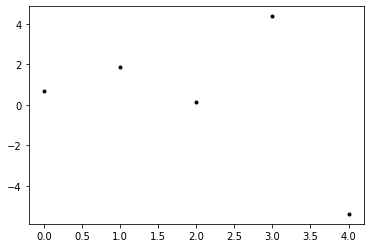

In [171]:
plt.plot(data.iloc[:,-1], 'k.')

In [102]:
data = pd.read_csv('pro.csv')

In [103]:
data = data.iloc[:,-1]

In [353]:
tot_mean = 0
a = 200
for i in range(a):
    bt_data = data.sample(n=200, replace=True)
    bt_data.mean()
    bt_sort_data = bt_data.sort_values()
    bt_mean = bt_sort_data.tail(100).mean()
    tot_mean+=bt_mean
    
tot_mean = tot_mean/a
print(tot_mean)

8.50331153544528


In [144]:
tot_mean = 0
for i in range(100):
    bt_data = data.sample(n=100, replace=True)
    bt_data.mean()
    bt_sort_data = bt_data.sort_values()
    bt_mean = bt_sort_data.tail(20).mean()
    tot_mean+=bt_mean
    
tot_mean = tot_mean/100
print(tot_mean)

11.07556763756416


In [ ]:
tot_mean = 0
for i in range(100):
    bt_data = data.sample(n=100, replace=True)
    bt_data.mean()
    bt_sort_data = bt_data.sort_values()
    bt_mean = bt_sort_data.tail(20).mean()
    tot_mean+=bt_mean
    
tot_mean = tot_mean/100
print(tot_mean)

In [15]:
result

[[53.1089250603801,
  30.929879954368086,
  73.2703754580228,
  129.35157387636207,
  165.7319629974911,
  85.98985934668326],
 [56.82454137849214,
  43.448973654952624,
  74.46709921216872,
  134.61568801637046,
  171.5292435131502,
  84.9086280317639],
 [64.93364931581453,
  94.77340427888744,
  64.36193725458848,
  162.574562641992,
  175.16149668928762,
  86.65155529097365]]

In [544]:
data = pd.read_csv('Squat Land Mark seyong2.csv')

In [545]:
#create new column in dataframe that contains Mahalanobis distance for each row
data['mahalanobis'] = mahalanobis(x=data,data=data[['right_knee', 'right_hip', 'right_ankle','right_hip2','right_neck','right_ankle2']])

C:\Users\user\anaconda3\envs\health\lib\site-packages\numpy\core\fromnumeric.py:3370: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [31]:
data2 = data.iloc[:,-1]

In [32]:
type(data2)

pandas.core.series.Series

In [6]:
data2 = data2.to_numpy()

In [15]:
import scipy.stats as st

In [8]:
# k = 자유도 

# 확률분포
st.chi2.pdf(x, k)

# 누적확률
st.chi2.cdf(x, k)

NameError: name 'x' is not defined

In [18]:
data.shape[1]

6

In [41]:
# 분위수
cutoff = st.chi2.ppf(0.9, data.shape[1])

In [42]:
cutoff

12.017036623780532

In [34]:
data2 > cutoff

0      True
1     False
2     False
3     False
4     False
5     False
6      True
7     False
8      True
9     False
10    False
11     True
12    False
13    False
14     True
15    False
16    False
17    False
18    False
19    False
Name: mahalanobis, dtype: bool

In [25]:
from itertools import chain
outlierIndexes = np.where(data2 > cutoff)
outlierIndexes = list(outlierIndexes)
outlierIndexes = list(chain(*outlierIndexes))

In [26]:
outlierIndexes

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [22]:
score = (len(data2) - len(outlierIndexes))/len(data2)*100

In [ ]:
0 3.8

In [23]:
print('%.1f점'%score)

0.0점


In [53]:
import numpy as np
from sklearn import datasets
from scipy.stats import f
def TwoSampleT2Test(X, Y):
    nx, p = X.shape
    ny, _ = Y.shape
    delta = np.mean(X, axis=0) - np.mean(Y, axis=0)
    Sx = np.cov(X, rowvar=False)
    Sy = np.cov(Y, rowvar=False)
    S_pooled = ((nx-1)*Sx + (ny-1)*Sy)/(nx+ny-2)
    t_squared = (nx*ny)/(nx+ny) * np.matmul(np.matmul(delta.transpose(), np.linalg.inv(S_pooled)), delta)
    statistic = t_squared * (nx+ny-p-1)/(p*(nx+ny-2))
    F = f(p, nx+ny-p-1)
    p_value = 1 - F.cdf(statistic)
    print(f"Test statistic: {statistic}\nDegrees of freedom: {p} and {nx+ny-p-1}\np-value: {p_value}")
    return statistic, p_value
iris = datasets.load_iris()
versicolor = iris.data[iris.target==1, :2]
virginica = iris.data[iris.target==2, :2]
TwoSampleT2Test(versicolor, virginica)

Test statistic: 15.82660099191812
Degrees of freedom: 2 and 97
p-value: 1.1259783253558808e-06


(15.82660099191812, 1.1259783253558808e-06)

In [54]:
iris_data = pd.DataFrame(data = np.c_[Iris['data'], Iris['target']], columns = Iris['featurer_names']+['target'])

NameError: name 'Iris' is not defined

In [45]:
TwoSampleT2Test(versicolor, virginica)

Test statistic: 15.82660099191812
Degrees of freedom: 2 and 97
p-value: 1.1259783253558808e-06


(15.82660099191812, 1.1259783253558808e-06)

In [46]:
type(iris)

sklearn.utils.Bunch

In [50]:
iris

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

In [49]:
iris = pd.DataFrame(iris)

ValueError: Per-column arrays must each be 1-dimensional

In [77]:
st.chi2.pdf(data2, k)

array([4.68236910e-05, 1.89486796e-07, 6.53935347e-10, 2.43404307e-06,
       3.04939842e-06, 1.81754654e-11, 5.51388286e-08, 1.32736967e-05,
       3.72037429e-07, 1.54483564e-10, 1.21869945e-05, 3.18704875e-11,
       5.81887695e-09, 2.73314182e-05, 3.06796616e-07, 1.87400750e-06,
       2.26329833e-16, 4.59079237e-08, 2.63631282e-11, 1.84783072e-06])

In [ ]:
# 1 평균의 위치
k = 9
avg = k    # 카이제곱분포의 평균은 자유도(k)

# 2. ﻿왼쪽, 오른쪽 면적이 각 0.05인 위치(ppf)
st.chi2.ppf(0.05, nu)  >>  3.325112843066815
st.chi2.ppf(0.95, nu)  >> 16.918977604620448

In [543]:
data = pd.read_csv('Squat Land Mark seyong2.csv')

In [85]:
data.to_csv('pro.csv', index=False)

In [81]:
data = pd.read_csv('Squat S_2.csv')

In [82]:
data

,right_knee,right_hip,right_ankle,right_hip2,right_neck,right_ankle2
0,61.292008,47.349013,77.639119,138.251355,161.911797,89.600152
1,60.562364,44.432202,77.888675,138.360620,170.441477,87.156454
2,59.913258,45.931485,77.831984,139.320627,165.668813,88.639595
3,62.162349,46.145253,74.681760,137.849232,169.519620,86.848812
4,60.427882,49.214262,75.276158,139.352687,163.867192,89.691265
...,...,...,...,...,...,...
1019,76.728801,72.114990,77.025030,145.034192,159.086081,90.930313
1020,64.012106,63.289380,71.487448,143.517090,164.041502,92.548520
1021,61.052776,61.385024,70.324267,144.950887,163.991730,91.488102
1022,60.042316,62.549976,72.977518,147.876421,152.006933,93.324086


In [57]:
list_df = data.values.tolist()

In [52]:
list_df

[[60.23615348583439,
  53.17362762217362,
  68.93894347211733,
  135.18426560469382,
  157.63390725772524,
  91.50074410826738],
 [53.482114885518,
  49.45093051710087,
  71.89961061122098,
  136.21030994265016,
  153.40966674326808,
  94.89328728730963],
 [54.46299556143339,
  50.28375337566977,
  69.57164321435734,
  136.23427445842665,
  153.5894392076683,
  94.11501139324224],
 [56.90517735965472,
  48.40985867376326,
  72.53679080749293,
  135.99040457406028,
  148.1136849080308,
  92.675350821596],
 [57.03092751722062,
  49.25716283496399,
  73.9581732160849,
  136.75942358295202,
  147.9629207628111,
  93.2592577475428],
 [55.046169929964265,
  47.242889413821885,
  76.22161097374097,
  135.91029463542029,
  152.89782508700426,
  94.96792372329242],
 [55.41360991037499,
  51.777279669005296,
  70.45951995737929,
  137.100039405344,
  150.3676016868882,
  93.33713695818444],
 [56.215472619385935,
  51.85124934499677,
  70.95841821108378,
  136.85158329605375,
  152.00724940308646

In [29]:
def mahalanobis(x=None, data=None, cov=None):

    x_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left = np.dot(x_mu, inv_covmat)
    mahal = np.dot(left, x_mu.T)
    return mahal.diagonal()

In [389]:
#create new column in dataframe that contains Mahalanobis distance for each row
data['mahalanobis'] = mahalanobis(x=data,data=data[['right_knee', 'right_hip', 'right_ankle','right_hip2','right_neck','right_ankle2']])

C:\Users\user\anaconda3\envs\health\lib\site-packages\numpy\core\fromnumeric.py:3370: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [34]:
data

,right_knee,right_hip,right_ankle,right_hip2,right_neck,right_ankle2,mahalanobis
0,60.236153,53.173628,68.938943,135.184266,157.633907,91.500744,8.726160
1,53.482115,49.450931,71.899611,136.210310,153.409667,94.893287,8.780045
2,54.462996,50.283753,69.571643,136.234274,153.589439,94.115011,4.907170
3,56.905177,48.409859,72.536791,135.990405,148.113685,92.675351,11.094592
4,57.030928,49.257163,73.958173,136.759424,147.962921,93.259258,5.994221
5,55.046170,47.242889,76.221611,135.910295,152.897825,94.967924,9.192387
6,55.413610,51.777280,70.459520,137.100039,150.367602,93.337137,9.011125
7,56.215473,51.851249,70.958418,136.851583,152.007249,94.417568,0.666375
8,56.315332,49.439284,73.910548,136.932265,155.247902,93.876452,2.847150
9,55.299114,50.889533,68.864612,137.043344,152.448591,92.736253,5.152355


In [50]:
mahala_mean = data.iloc[:,-1].mean()

In [ ]:
{}

In [51]:
mahala_mean = list(mahala_mean)

TypeError: 'numpy.float64' object is not iterable

In [143]:
data.to_csv('C:\\Users\\user\\graduation_work\\mahalano.csv', index=False)

In [535]:
data = pd.read_csv('mahalano.csv')

In [14]:
data3 = data2.sample(frac=1).reset_index(drop=True)

In [511]:
data = pd.read_csv('Squat Land Mark seyong2.csv')
#create new column in dataframe that contains Mahalanobisdistance for each row
data['mahalanobis'] = mahalanobis(x=data,data=data[['right_knee', 'right_hip', 'right_ankle','right_hip2','right_neck','right_ankle2']])

C:\Users\user\anaconda3\envs\health\lib\site-packages\numpy\core\fromnumeric.py:3370: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [501]:
data.mean()

right_knee       67.682147
right_hip        45.677335
right_ankle      85.913618
right_hip2      132.416412
right_neck      138.049261
right_ankle2     93.500007
mahalanobis       5.700000
dtype: float64

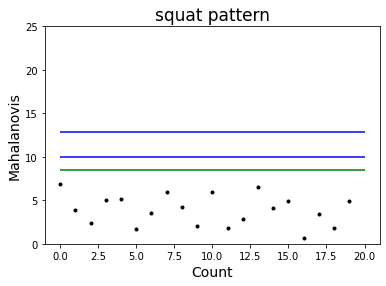

In [536]:
plt.title('squat pattern', fontsize=17)
plt.ylim(0,25)
plt.plot(data, 'k.')
plt.xlabel("Count", fontsize=14)
plt.ylabel("Mahalanovis", fontsize=14)
plt.hlines(y=12.8, xmin=0, xmax=len(data), linestyle='solid', color = 'blue')
plt.hlines(y=10, xmin=0, xmax=len(data), linestyle='solid', color = 'blue')
plt.hlines(y=8.5, xmin=0, xmax=len(data), linestyle='solid', color = 'green')

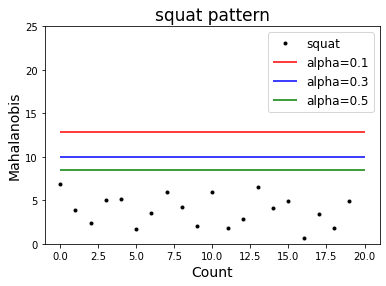

In [538]:
plt.title('squat pattern', fontsize=17)
plt.ylim(0,25)
plt.plot(data.iloc[:,-1], 'k.')
plt.xlabel("Count", fontsize=14)
plt.ylabel("Mahalanobis", fontsize=14)
plt.hlines(y=12.8, xmin=0, xmax=len(data), linestyle='solid', color = 'red')
plt.hlines(y=10, xmin=0, xmax=len(data), linestyle='solid', color = 'blue')
plt.hlines(y=8.5, xmin=0, xmax=len(data), linestyle='solid', color = 'green')
plt.legend(['squat','alpha=0.1','alpha=0.3','alpha=0.5'], fontsize=12)

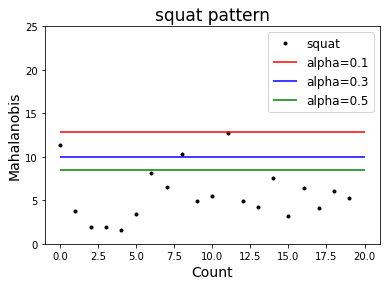

In [546]:
plt.title('squat pattern', fontsize=17)
plt.ylim(0,25)
plt.plot(data.iloc[:,-1], 'k.')
plt.xlabel("Count", fontsize=14)
plt.ylabel("Mahalanobis", fontsize=14)
plt.hlines(y=12.8, xmin=0, xmax=len(data), linestyle='solid', color = 'red')
plt.hlines(y=10, xmin=0, xmax=len(data), linestyle='solid', color = 'blue')
plt.hlines(y=8.5, xmin=0, xmax=len(data), linestyle='solid', color = 'green')
plt.legend(['squat','alpha=0.1','alpha=0.3','alpha=0.5'], fontsize=12)

In [452]:
from itertools import chain
outlierIndexes = np.where(data.iloc[:,-1] > 8.5)
outlierIndexes = list(outlierIndexes)
outlierIndexes = list(chain(*outlierIndexes))

In [503]:
outlierIndexes

[0, 8, 11]

In [513]:
data

,right_knee,right_hip,right_ankle,right_hip2,right_neck,right_ankle2,mahalanobis
0,71.106512,45.906974,85.332092,129.434287,149.606467,93.876903,11.410796
1,69.857743,49.805739,86.409966,133.448620,138.522623,95.908018,3.738191
2,70.402139,48.706834,86.905437,132.483602,142.336333,95.230885,1.877685
3,70.293506,49.232010,84.855886,132.801686,139.578060,94.214323,1.892502
4,70.899600,49.652500,85.653201,132.623366,142.411048,95.000190,1.579595
5,72.432360,49.513119,86.682570,131.925439,142.264790,94.741655,3.476842
6,69.178656,49.015521,84.015891,133.492624,139.225965,94.345595,8.123551
7,70.488021,50.822920,83.471821,133.803748,138.256393,92.177983,6.584858
8,74.359320,50.156199,86.381050,132.303807,146.404126,92.702115,10.371037
9,72.641513,50.850474,88.546333,133.330755,143.714947,95.486206,4.874040


In [ ]:
def mahalanobis(x=None, data=None, cov=None):

    x_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left = np.dot(x_mu, inv_covmat)
    mahal = np.dot(left, x_mu.T)
    return mahal.diagonal()

In [505]:
data['mahalanobis_knee'] = mahalanobis(x=data.iloc[:,1:-1], data=data[['right_hip', 'right_ankle','right_hip2','right_neck','right_ankle2']])

C:\Users\user\anaconda3\envs\health\lib\site-packages\numpy\core\fromnumeric.py:3370: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [517]:
data_knee = data.drop(['right_knee','mahalanobis'], axis=1)
data_hip = data.drop(['right_hip','mahalanobis'], axis=1)
data_ankle = data.drop(['right_ankle','mahalanobis'], axis=1)
data_hip2 = data.drop(['right_hip2','mahalanobis'], axis=1)
data_neck = data.drop(['right_neck','mahalanobis'], axis=1)
data_ankle2 = data.drop(['right_ankle2','mahalanobis'], axis=1)

In [521]:
data['mhn_knee'] = mahalanobis(x=data_knee, data=data[['right_hip', 'right_ankle','right_hip2','right_neck','right_ankle2']])

C:\Users\user\anaconda3\envs\health\lib\site-packages\numpy\core\fromnumeric.py:3370: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [ ]:
data['mhn_hip'] = mahalanobis(x=data_hip, data=data_hip)

In [526]:
data['mhn_ankle'] = mahalanobis(x=data_ankle, data=data_ankle)
data['mhn_hip2'] = mahalanobis(x=data_hip2, data=data_hip2)
data['mhn_neck'] = mahalanobis(x=data_neck, data=data_neck)
data['mhn_ankle2'] = mahalanobis(x=data_ankle2, data=data_ankle2)

C:\Users\user\anaconda3\envs\health\lib\site-packages\numpy\core\fromnumeric.py:3370: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\user\anaconda3\envs\health\lib\site-packages\numpy\core\fromnumeric.py:3370: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\user\anaconda3\envs\health\lib\site-packages\numpy\core\fromnumeric.py:3370: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs

In [530]:
data.iloc[0,6:]

mahalanobis    11.410796
mhn_knee       10.873139
mhn_hip        10.621884
mhn_ankle      10.903809
mhn_hip2        8.703279
mhn_neck       11.384659
mhn_ankle2     11.267892
Name: 0, dtype: float64

In [532]:
data.iloc[8,6:]

mahalanobis    10.371037
mhn_knee        8.098267
mhn_hip         8.781468
mhn_ankle      10.164876
mhn_hip2        8.713753
mhn_neck        9.807267
mhn_ankle2     10.053792
Name: 8, dtype: float64

In [533]:
data.iloc[11,6:]

mahalanobis    12.735610
mhn_knee       12.471203
mhn_hip        12.597412
mhn_ankle      12.727494
mhn_hip2       12.012733
mhn_neck        5.877242
mhn_ankle2     12.647090
Name: 11, dtype: float64

In [446]:
data['mahalanobis_knee'] = mahalanobis(x=data.iloc[:,1:-1] ,data=data[['right_hip', 'right_ankle','right_hip2','right_neck','right_ankle2']])

C:\Users\user\anaconda3\envs\health\lib\site-packages\numpy\core\fromnumeric.py:3370: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [447]:
data

,right_knee,right_hip,right_ankle,right_hip2,right_neck,right_ankle2,mahalanobis,mahalanobis_knee
0,71.106512,45.906974,85.332092,129.434287,149.606467,93.876903,11.410796,10.873139
1,69.857743,49.805739,86.409966,133.448620,138.522623,95.908018,3.738191,3.730879
2,70.402139,48.706834,86.905437,132.483602,142.336333,95.230885,1.877685,1.463196
3,70.293506,49.232010,84.855886,132.801686,139.578060,94.214323,1.892502,1.620725
4,70.899600,49.652500,85.653201,132.623366,142.411048,95.000190,1.579595,1.575500
5,72.432360,49.513119,86.682570,131.925439,142.264790,94.741655,3.476842,3.462689
6,69.178656,49.015521,84.015891,133.492624,139.225965,94.345595,8.123551,4.047954
7,70.488021,50.822920,83.471821,133.803748,138.256393,92.177983,6.584858,6.406614
8,74.359320,50.156199,86.381050,132.303807,146.404126,92.702115,10.371037,8.098267
9,72.641513,50.850474,88.546333,133.330755,143.714947,95.486206,4.874040,4.538047


In [437]:
data.iloc[0,:-2]

right_knee      71.106512
right_hip       45.906974
right_ankle     85.332092
right_hip2     129.434287
right_neck     149.606467
Name: 0, dtype: float64

In [ ]:
data.iloc[0,:-2]

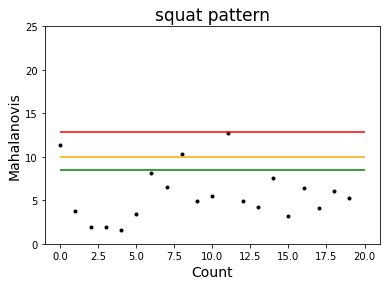

In [406]:
plt.title('squat pattern', fontsize=17)
plt.ylim(0,25)
plt.plot(data, 'k.')
plt.xlabel("Count", fontsize=14)
plt.ylabel("Mahalanovis", fontsize=14)
plt.hlines(y=12.8, xmin=0, xmax=len(data), linestyle='solid', color = 'red')
plt.hlines(y=10, xmin=0, xmax=len(data), linestyle='solid', color = 'orange')
plt.hlines(y=8.5, xmin=0, xmax=len(data), linestyle='solid', color = 'green')

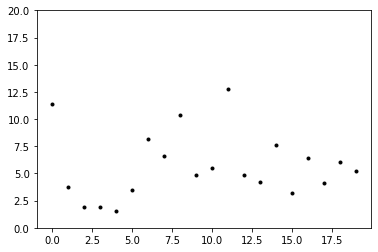

In [24]:
plt.ylim(0,20)
plt.plot(data.iloc[:,-1], 'k.')

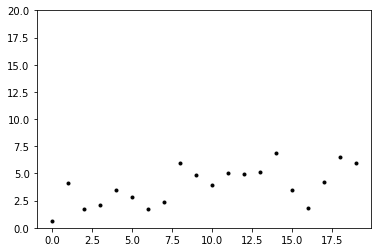

In [26]:
plt.ylim(0,20)
plt.plot(data3.iloc[:,-1], 'k.')

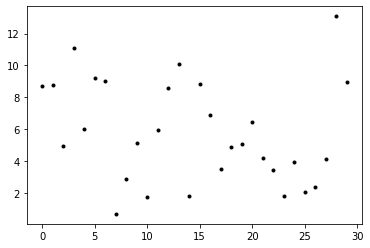

In [76]:
plt.plot(data.iloc[:,-1], 'k.')

In [106]:
maha_sum = sum(data.iloc[:,-1])

In [107]:
maha_avg = maha_sum / len(data)

In [108]:
maha_avg

5.800000000000003

In [77]:
data.iloc[:,-1]

0      8.726160
1      8.780045
2      4.907170
3     11.094592
4      5.994221
5      9.192387
6      9.011125
7      0.666375
8      2.847150
9      5.152355
10     1.715214
11     5.940659
12     8.610208
13    10.110394
14     1.800138
15     8.803259
16     6.865372
17     3.498247
18     4.900305
19     5.036986
20     6.473764
21     4.189812
22     3.439216
23     1.770955
24     3.928368
25     2.064100
26     2.342617
27     4.113029
28    13.093312
29     8.932467
Name: mahalanobis, dtype: float64

In [115]:
ee = data.iloc[:,-1].tolist

In [117]:
type(e

method

In [78]:
#분산평균 -> line
mean_var =np.mean(data.iloc[:,-1])

In [79]:
mean_var

5.800000000000003

In [150]:
type(ex)

pandas.core.series.Series

In [94]:
ex = []

In [109]:
for i in range(30):
    ex.append(data.iloc[i,-1] - mean_var)

In [100]:
mape = 0
for i in range(len(data)):
    exe = abs(data.iloc[i,-1] - mean_var)
    mape += exe / abs(data.iloc[i,-1]) * 100
mape = mape/len(data)


In [102]:
exe = abs(data.iloc[i,-1] - mean_var)

In [110]:
exe

3.132466977135718

In [104]:
exe / abs(data.iloc[1,-1])

0.35677118957901494

In [101]:
mape

87.85863957569588

In [99]:
len(data)

30

In [97]:
exe = abs(data.iloc[1,-1] - mean_var)
mape = exe / abs(data.iloc[1,-1]) * 100

In [98]:
mape

33.94111048377593

In [90]:
data.iloc[,-1]

4.9071696150095985

In [111]:
ex

[2.9261604063951543,
 2.9800446578435453,
 -0.8928303849904049,
 5.29459232104231,
 0.1942206445226633,
 3.3923872872614327,
 3.2111245049283346,
 -5.13362521390882,
 -2.9528504205679154,
 -0.6476446257221387,
 -4.084786230928658,
 0.14065932287051197,
 2.8102079743372164,
 4.310393622856895,
 -3.999862032065181,
 3.0032586010310363,
 1.0653720064518977,
 -2.301752969141271,
 -0.8996953397203642,
 -0.763013680814173,
 0.6737641118758395,
 -1.6101882337891817,
 -2.360784395611597,
 -4.029045154199954,
 -1.8716321128809583,
 -3.7358998216539816,
 -3.457382905444213,
 -1.6869709816670841,
 7.293312064553343,
 3.132466977135718,
 2.9261604063951543,
 2.9800446578435453,
 -0.8928303849904049,
 5.29459232104231,
 0.1942206445226633,
 3.3923872872614327,
 3.2111245049283346,
 -5.13362521390882,
 -2.9528504205679154,
 -0.6476446257221387,
 -4.084786230928658,
 0.14065932287051197,
 2.8102079743372164,
 4.310393622856895,
 -3.999862032065181,
 3.0032586010310363,
 1.0653720064518977,
 -2.301752

In [112]:
ex1= ex.tolist

AttributeError: 'list' object has no attribute 'tolist'

In [155]:
type(ex1)

method

In [160]:
abs(ex1)

TypeError: bad operand type for abs(): 'method'

In [113]:
ex.sort()

In [114]:
ex

[-5.13362521390882,
 -5.13362521390882,
 -4.084786230928658,
 -4.084786230928658,
 -4.029045154199954,
 -4.029045154199954,
 -3.999862032065181,
 -3.999862032065181,
 -3.7358998216539816,
 -3.7358998216539816,
 -3.457382905444213,
 -3.457382905444213,
 -2.9528504205679154,
 -2.9528504205679154,
 -2.360784395611597,
 -2.360784395611597,
 -2.301752969141271,
 -2.301752969141271,
 -1.8716321128809583,
 -1.8716321128809583,
 -1.6869709816670841,
 -1.6869709816670841,
 -1.6101882337891817,
 -1.6101882337891817,
 -0.8996953397203642,
 -0.8996953397203642,
 -0.8928303849904049,
 -0.8928303849904049,
 -0.763013680814173,
 -0.763013680814173,
 -0.6476446257221387,
 -0.6476446257221387,
 0.14065932287051197,
 0.14065932287051197,
 0.1942206445226633,
 0.1942206445226633,
 0.6737641118758395,
 0.6737641118758395,
 1.0653720064518977,
 1.0653720064518977,
 2.8102079743372164,
 2.8102079743372164,
 2.9261604063951543,
 2.9261604063951543,
 2.9800446578435453,
 2.9800446578435453,
 3.003258601031036

In [15]:
x_input

[57.177674663958726,
 37.793680208210816,
 86.71058616625841,
 133.83223558043443,
 163.8864995845133,
 95.91959169456624]

In [17]:
load_model.predict([x_input])

C:\Users\user\anaconda3\envs\health\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([0], dtype=int64)

### 3 프레임 활용

In [ ]:
# setup pose_video
pose_video = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, model_complexity=1)

# setting videocapture with webcam
video = cv2.VideoCapture('Squat Sample.mp4')
cv2.namedWindow('Pose Detection', cv2.WINDOW_NORMAL)
video.set(3,1280)
video.set(4,960)
time1 = 0
count = 0
previous_knee_angle = 300
previous_hip_angle = 300
x_input = []
check_point = 0
cla = 'CLASS : None'
state = 'stand'
pred = 0

# iterate video
while video.isOpened():
    
    # read frame
    ok, frame = video.read()
    
    # read frame x
    if not ok:
        
        continue
    
    # horizontal flip (selfie) # 좌우반전 1이 좌우반전. 0은 상하반전
    #frame = cv2.flip(frame, 0)
    
    # get height & width
    frame_height, frame_width, _ =  frame.shape
    
    # resize frame (keep aspect ratio)
    frame = cv2.resize(frame, (int(frame_width * (1920 / frame_height)), 1080))
    
    # "detectPose" model landmark detection
    frame, angle = detectPose(frame, pose_video, display = False)
    
    
    if len(angle) != 0:
        
        r_knee_angle = angle[0]
        r_hip_angle = angle[1] 
        
        if r_knee_angle < 100:
            if check_point == 0:
                if (r_knee_angle > previous_knee_angle) & (r_hip_angle > previous_hip_angle):
                    state = 'squat'
                    pred0 = load_model.predict([x_input])
                    pred1 = load_model.predict([angle])
                    pred2 = load_model.predict([x_input2])
                    
                    if pred0 == 1:
                        pred += 1
                    if pred1 == 1:
                        pred += 1
                    if pred2 == 1:
                        pred += 1
                    
                    if pred <= 1:
                        cla = 'CLASS : BAD' 
                    else:
                        cla = 'CLASS : GOOD' 
            
                    check_point = 1
                            
    previous_knee_angle = r_knee_angle
    previous_hip_angle = r_hip_angle
    x_input2 = x_input
    x_input = angle
        
    if (state == 'squat') & (r_knee_angle > 155):
        if cla == 'CLASS : GOOD':
            count += 1
        check_point = 0
        state = 'stand'
        cla = 'CLASS : None'
        pred = 0
    
    # time set (frame)
    time2 = time()

    if (time2 - time1) > 0:
        frames_per_second = 1.0 / (time2 - time1)
        cv2.putText(frame, 'FPS: {}'.format(int(frames_per_second)), (10, 30),cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 3)
        
    time1 = time2
 
    cv2.putText(frame, 'COUNT: {}'.format(count), (10, 110) ,cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 3)
    if cla== 'CLASS : BAD':
        cv2.putText(frame, cla, (10, 70) ,cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), 3)
    elif cla == 'CLASS : GOOD':
        cv2.putText(frame, cla, (10, 70) ,cv2.FONT_HERSHEY_PLAIN, 2, (255, 0, 0), 3)
    else:
        cv2.putText(frame, cla, (10, 70) ,cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 3)
    
    # display frame.
    cv2.imshow('Pose Detection', frame)
    
    k = cv2.waitKey(1) & 0xFF
    
    # close with ESC
    if(k == 27):
        
        break

video.release()
cv2.destroyAllWindows()

In [44]:
'''
# setup pose_video
pose_video = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, model_complexity=1)

# setting videocapture with webcam
video = cv2.VideoCapture('Squat Sample.mp4')
cv2.namedWindow('Pose Detection', cv2.WINDOW_NORMAL)
video.set(3,1280)
video.set(4,960)
time1 = 0
count = 0
previous_right_knee_angle = 300
x_input = []
check_point = 0
cla = 'CLASS : None'
state = 'stand'
x_input2 = []
pred = []
check = 0
good = 0
bad = 0

# iterate video
while video.isOpened():
    
    # read frame
    ok, frame = video.read()
    
    # read frame x
    if not ok:
        
        continue
    
    # horizontal flip (selfie) # 좌우반전 1이 좌우반전. 0은 상하반전
    #frame = cv2.flip(frame, 0)
    
    # get height & width
    frame_height, frame_width, _ =  frame.shape
    
    # resize frame (keep aspect ratio)
    frame = cv2.resize(frame, (int(frame_width * (1920 / frame_height)), 1080))
    
    # "detectPose" model landmark detection
    frame, angle = detectPose(frame, pose_video, display = False)
    
    
    if len(angle) != 0:
        
        right_knee_angle = angle[0]
        right_hip_angle = angle[1]
            
        if right_knee_angle < 100:
            if check_point == 0:
                if (right_knee_angle > previous_right_knee_angle) & (right_hip_angle > previous_right_hip_angle):
                    state = 'squat'
                    
                    x_input2.append(x_input.pop())
                    x_input2.append(x_input.pop())
                    x_input2.append(x_input.pop())
                    x_input2.append(x_input.pop())
                    x_input2.append(x_input.pop())
                    x_input2.append(x_input.pop())
            
                    check_point = 1
                    check = 1
                    
    previous_right_knee_angle = right_knee_angle
    previous_right_hip_angle = right_hip_angle
    x_input.append(angle)
    
    if (check_point == 1) & (1 <= check <= 5):
        x_input2.append(x_input.pop())
        check += 1
        
        if check == 6:
            pred.extend(load_model.predict([x_input2[5]]))
            pred.extend(load_model.predict([x_input2[4]]))
            pred.extend(load_model.predict([x_input2[3]]))
            pred.extend(load_model.predict([x_input2[2]]))
            pred.extend(load_model.predict([x_input2[1]]))
            pred.extend(load_model.predict([x_input2[0]]))
            pred.extend(load_model.predict([x_input2[6]]))
            pred.extend(load_model.predict([x_input2[7]]))
            pred.extend(load_model.predict([x_input2[9]]))
            pred.extend(load_model.predict([x_input2[10]]))
            pred.extend(load_model.predict([x_input2[11]]))
            
            for i in range(12):
                if pred[i] == 1:
                    good += 1
                else:
                    bad += 1
            
            if good > bad:
                cla == 'CLASS : GOOD'
            else:
                cla == 'CLASS ; BAD'
            
    if (state == 'squat') & (right_knee_angle > 155):
        if cla == 'CLASS : GOOD':
            count += 1
        check_point = 0
        x_input = []
        check = 0
        state = 'stand'
        cla = 'CLASS : None'
    
    # time set (frame)
    time2 = time()

    if (time2 - time1) > 0:
        frames_per_second = 1.0 / (time2 - time1)
        cv2.putText(frame, 'FPS: {}'.format(int(frames_per_second)), (10, 30),cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 3)
        
    time1 = time2
 
    cv2.putText(frame, 'COUNT: {}'.format(count), (10, 110) ,cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 3)
    if cla== 'CLASS : BAD':
        cv2.putText(frame, cla, (10, 70) ,cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), 3)
    elif cla == 'CLASS : GOOD':
        cv2.putText(frame, cla, (10, 70) ,cv2.FONT_HERSHEY_PLAIN, 2, (255, 0, 0), 3)
    else:
        cv2.putText(frame, cla, (10, 70) ,cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 3)
    
    # display frame.
    cv2.imshow('Pose Detection', frame)
    
    k = cv2.waitKey(1) & 0xFF
    
    # close with ESC
    if(k == 27):
        
        break

video.release()
cv2.destroyAllWindows()
'''

C:\Users\user\anaconda3\envs\health\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\anaconda3\envs\health\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\anaconda3\envs\health\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\anaconda3\envs\health\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\anaconda3\envs\health\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Us

IndexError: list index out of range

In [9]:
x

[143.73757551518372,
 147.98660239682326,
 107.70512445598116,
 162.83232789937483,
 142.06677608933236,
 104.20717653457274]

In [10]:
load_model.predict([[]])

ValueError: Found array with 0 feature(s) (shape=(1, 0)) while a minimum of 1 is required.

# 이슈
### 1 데이터셋 화면비율 / 크기
### 2 실시간 화면비율 / 크기
### 3 지금 스탠드와 스쿼트 정의를 오른쪽 무릎 각도로 지정하였는데 이외에 다른 방법 찾기
### 4 

In [ ]:
x

In [70]:
# setup pose_video
pose_video = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, model_complexity=1)

# setting videocapture with webcam
video = cv2.VideoCapture('KakaoTalk_20220321_160112717.mp4')
cv2.namedWindow('Pose Detection', cv2.WINDOW_NORMAL)
video.set(3,1280)
video.set(4,960)
time1 = 0
count = 0
previous_angle = 300
x_input = []
check_point =0 
cla = 'CLASS : None'
state = 'stand'

# iterate video
while video.isOpened():
    
    # read frame
    ok, frame = video.read()
    
    # read frame x
    if not ok:
        
        continue
    
    # horizontal flip (selfie) # 좌우반전 1이 좌우반전. 0은 상하반전
    frame = cv2.flip(frame, 1)
    
    # get height & width
    frame_height, frame_width, _ =  frame.shape
    
    # resize frame (keep aspect ratio)
    frame = cv2.resize(frame, (int(frame_width * (1920 / frame_height)), 1080))
    
    # "detectPose" model landmark detection
    frame, angle = detectPose(frame, pose_video, display = False)
    
    
    if len(angle) != 0:
        
        r_angle = angle[0]
            
        if r_angle < 100:
            if check_point == 0:
                if r_angle > previous_angle:
                    state = 'squat'
                    pred = load_model.predict([x_input])
                    if pred == 0:
                        cla = 'CLASS : 0' 
                    else:
                        cla = 'CLASS : 1' 
            
                    check_point = 1
             
                    
    previous_angle = r_angle
    x_input = angle

    if (state == 'squat') & (r_angle > 165):
        count += 1
        check_point = 0
        state = 'stand'
        cla = 'CLASS : None'
    
    # time set (frame)
    time2 = time()

    if (time2 - time1) > 0:
        frames_per_second = 1.0 / (time2 - time1)
        cv2.putText(frame, 'FPS: {}'.format(int(frames_per_second)), (30, 30),cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 3)
        
    time1 = time2
 
    cv2.putText(frame, 'COUNT: {}'.format(count), (100, 300) ,cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 3)
    cv2.putText(frame, cla, (100, 100) ,cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 3)

    
    # display frame.
    cv2.imshow('Pose Detection', frame)
    
    k = cv2.waitKey(1) & 0xFF
    
    # close with ESC
    if(k == 27):
        
        break

video.release()
cv2.destroyAllWindows()

C:\Users\user\anaconda3\envs\health\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [11]:
# setup pose_video
pose_video = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, model_complexity=1)

# setting videocapture with webcam
video = cv2.VideoCapture('KakaoTalk_20220321_160112717.mp4')
cv2.namedWindow('Pose Detection', cv2.WINDOW_NORMAL)
video.set(3,1280)
video.set(4,960)
time1 = 0
count = 0
previous_angle = 300
x_input = []
check_point =0 
cla = 'CLASS : None'
state = 'stand'

# iterate video
while video.isOpened():
    
    # read frame
    ok, frame = video.read()
    
    # read frame x
    if not ok:
        
        continue
    
    # horizontal flip (selfie) # 좌우반전 1이 좌우반전. 0은 상하반전
    frame = cv2.flip(frame, 1)
    
    # get height & width
    frame_height, frame_width, _ =  frame.shape
    
    # resize frame (keep aspect ratio)
    frame = cv2.resize(frame, (int(frame_width * (1920 / frame_height)), 1080))
    
    # "detectPose" model landmark detection
    frame, angle = detectPose(frame, pose_video, display = False)
    
    
    if len(angle) != 0:
        
        r_angle = angle[0]
            
        if r_angle < 100:
            if check_point == 0:
                if r_angle > previous_angle:
                    state = 'squat'
                    pred = load_model.predict([x_input])
                    if pred == 0:
                        cla = 'CLASS : 0' 
                    else:
                        cla = 'CLASS : 1' 
            
                    check_point = 1
             
                    
    previous_angle = r_angle
    x_input = angle

    if (state == 'squat') & (r_angle > 165):
        count += 1
        check_point = 0
        state = 'stand'
        cla = 'CLASS : None'
    
    # time set (frame)
    time2 = time()

    if (time2 - time1) > 0:
        frames_per_second = 1.0 / (time2 - time1)
        cv2.putText(frame, 'FPS: {}'.format(int(frames_per_second)), (30, 30),cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 3)
        
    time1 = time2
 
    cv2.putText(frame, 'COUNT: {}'.format(count), (100, 300) ,cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 3)
    cv2.putText(frame, cla, (100, 100) ,cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 3)

    
    # display frame.
    cv2.imshow('Pose Detection', frame)
    
    k = cv2.waitKey(1) & 0xFF
    
    # close with ESC
    if(k == 27):
        
        break

video.release()
cv2.destroyAllWindows()

In [ ]:
'''
# setup pose_video
pose_video = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, model_complexity=1)

# setting videocapture with webcam
video = cv2.VideoCapture('KakaoTalk_20220321_160112717.mp4')
cv2.namedWindow('Pose Detection', cv2.WINDOW_NORMAL)
video.set(3,1280)
video.set(4,960)
time1 = 0
count = 0
a = 200
x = []
b =0 

# iterate video
while video.isOpened():
    
    # read frame
    ok, frame = video.read()
    
    # read frame x
    if not ok:
        
        continue
    
    # horizontal flip (selfie) # 좌우반전 1이 좌우반전. 0은 상하반전
    frame = cv2.flip(frame, 1)
    
    # get height & width
    frame_height, frame_width, _ =  frame.shape
    
    # resize frame (keep aspect ratio)
    frame = cv2.resize(frame, (int(frame_width * (640 / frame_height)), 640))
    
        if len(angle) != 0:
        
            r_angle = angle[0]
            if angle_right_knee < 165:

            if b == 0:
                if r_angle > a:
                    pred = load_model.predict([x])
                    if pred == 0:
                        cv2.putText(frame, 'CLASS: 0', (100, 100) ,cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 3)
                        count += 1
                    else:
                        cv2.putText(frame, 'CLASS: 1', (100, 100) ,cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 3)
                        count += 1
            
                    b = 1
    
        a = r_angle
        x = angle
        
    mp_drawing.draw_landmarks(image=output_image, landmark_list=results.pose_landmarks,
                                  connections=mp_pose.POSE_CONNECTIONS)
    
    # time set (frame)
    time2 = time()

    if (time2 - time1) > 0:
        frames_per_second = 1.0 / (time2 - time1)
        cv2.putText(frame, 'FPS: {}'.format(int(frames_per_second)), (30, 30),cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 3)
        
    time1 = time2
 
    cv2.putText(frame, 'COUNT: {}'.format(count), (100, 300) ,cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 3)
    
    
    
    # display frame.
    cv2.imshow('Pose Detection', frame)
    
    k = cv2.waitKey(1) & 0xFF
    
    # close with ESC
    if(k == 27):
        
        break

video.release()
cv2.destroyAllWindows()